In [5]:
!pip install opendatasets

In [6]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt
import numpy as np

# Data Collection, Preprocessing

#####  Load data into tf.Dataset

In [76]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [77]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
    "RiceDiseases",
    shuffle=True,
    image_size = (IMAGE_SIZE, IMAGE_SIZE),
    batch_size = BATCH_SIZE    
)

Found 2254 files belonging to 5 classes.


In [78]:
class_names = dataset.class_names
class_names

['Bacterial_Leaf_Blight',
 'Brown_Spot',
 'Healthy',
 'Leaf_Scald',
 'Narrow_Brown_Spot']

In [79]:
len(dataset) #length of the dataset

71

In [80]:
for image_batch, label_batch in dataset.take(1):
    plt.show()
    print("Image batch size", image_batch.shape)
    print("Label batch", label_batch.numpy())

Image batch size (32, 256, 256, 3)
Label batch [0 3 2 2 2 2 3 3 3 2 1 3 2 0 4 4 0 1 2 4 0 3 4 4 1 0 3 2 1 4 0 2]


#### Data visualization

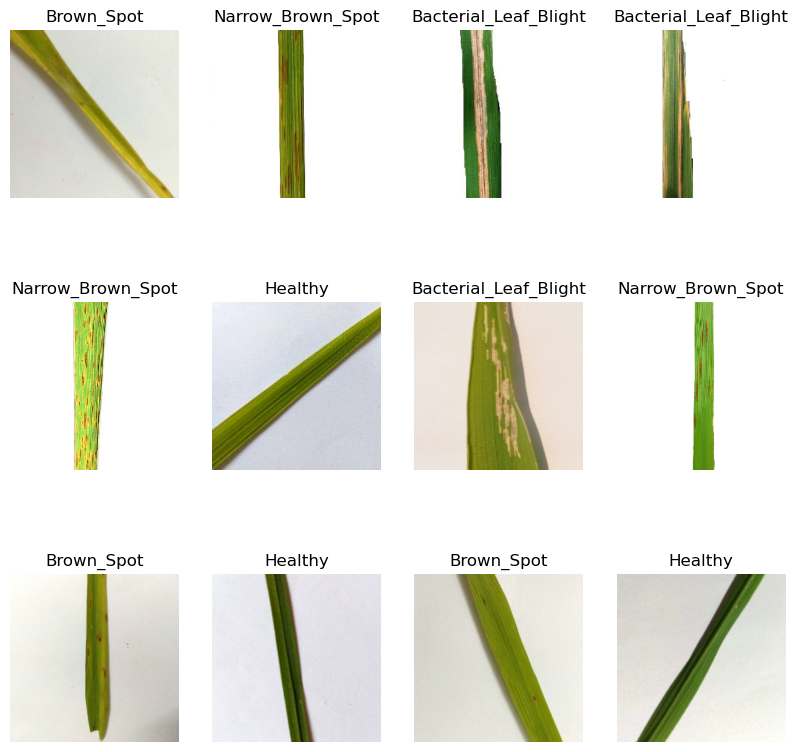

In [81]:
plt.figure(figsize = (10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        plt.subplot(3,4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

#### Train test split

In [82]:
# 80% ==> training
# 20% ==> 10% validation, 10% test

In [83]:
# ////...........Way 1.................////

In [84]:
train_size =0.8
len(dataset)* train_size

56.800000000000004

In [85]:
train_ds =  dataset.take(23)
len(train_ds)

23

In [86]:
test_ds = dataset.skip(23) #arr[:54]
len(test_ds)

48

In [87]:
val_size = 0.1
len(dataset)*val_size

7.1000000000000005

In [88]:
val_ds = test_ds.take(2)
len(val_ds)

2

In [89]:
test_ds = test_ds.skip(2)
len(test_ds)

46

In [90]:
# ////...........Way 2.................////

In [91]:
def get_dataset_partition_tf(ds, train_split = 0.8 , val_split = 0.1, test_split = 0.1, shuffle= True, shuffle_size = 10000):
    ds_size = len(ds)
    if shuffle:
        ds = ds.shuffle(shuffle_size, seed = 12)
    
    train_size = int(train_split * ds_size)
    
    val_size = int(val_split * ds_size)
    
    train_ds = ds.take(train_size)
    
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)
    
    return train_ds, val_ds, test_ds

In [92]:
train_ds, val_ds, test_ds = get_dataset_partition_tf(dataset,)

In [93]:
len(train_ds)

56

In [94]:
len(val_ds)

7

In [95]:
len(test_ds)

8

In [96]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)
test_ds = test_ds.cache().shuffle(1000).prefetch(buffer_size = tf.data.AUTOTUNE)

# Data Augumentation

In [97]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE), #Resize the images
    layers.experimental.preprocessing.Rescaling(1.0/255)
])

In [98]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2)
])

# Build the model

In [99]:
# 01. Fisrt define the deep leaning NN architecture 

In [100]:
input_shape = (BATCH_SIZE, IMAGE_SIZE,IMAGE_SIZE, CHANNELS)
n_classes = 5

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape = input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size = (3,3),  activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64 ,kernel_size = (3,3),  activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation = 'relu'),
    layers.Dense(n_classes, activation = 'softmax'), #normalize the probebilit of the class
])

model.build(input_shape = input_shape)

In [101]:
model.summary()

Model: "sequential_6"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential_4 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 sequential_5 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d_10 (Conv2D)          (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d_10 (MaxPooli  (32, 127, 127, 32)        0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_11 (MaxPooli  (32, 62, 62, 64)          0         
 ng2D)                                                

In [102]:
# 02. Then compile

In [103]:
model.compile(
    optimizer = 'adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits = False),
    metrics = ['accuracy'] #Track the training process
)

In [104]:
# 03. Train the network

In [105]:
history = model.fit(
    train_ds,
    epochs = EPOCHS,
    batch_size = BATCH_SIZE,
    verbose = 1,
    validation_data = val_ds
)

Epoch 1/50
56/56 [==============================] - 51s 807ms/step - loss: 1.5202 - accuracy: 0.3067 - val_loss: 1.3108 - val_accuracy: 0.4272
Epoch 2/50
56/56 [==============================] - 36s 638ms/step - loss: 1.3130 - accuracy: 0.4369 - val_loss: 1.1191 - val_accuracy: 0.5534
Epoch 3/50
56/56 [==============================] - 37s 658ms/step - loss: 1.2199 - accuracy: 0.4617 - val_loss: 1.1896 - val_accuracy: 0.4951
Epoch 4/50
56/56 [==============================] - 37s 660ms/step - loss: 1.1896 - accuracy: 0.4859 - val_loss: 1.0269 - val_accuracy: 0.5971
Epoch 5/50
56/56 [==============================] - 36s 650ms/step - loss: 1.2076 - accuracy: 0.4887 - val_loss: 1.0507 - val_accuracy: 0.5437
Epoch 6/50
56/56 [==============================] - 37s 660ms/step - loss: 1.1290 - accuracy: 0.5186 - val_loss: 1.0473 - val_accuracy: 0.5583
Epoch 7/50
56/56 [==============================] - 37s 662ms/step - loss: 1.0702 - accuracy: 0.5333 - val_loss: 0.9716 - val_accuracy: 0.5680

####  Plot training history on graph

In [106]:
scores = model.evaluate(test_ds)

8/8 [==============================] - 8s 172ms/step - loss: 0.1761 - accuracy: 0.9538


In [107]:
scores

[0.17611142992973328, 0.9537814855575562]

In [108]:
history


In [109]:
history.params

{'verbose': 1, 'epochs': 50, 'steps': 56}

In [110]:
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [111]:
history.history['accuracy']

[0.30665162205696106,
 0.43686583638191223,
 0.46166855096817017,
 0.48590755462646484,
 0.48872604966163635,
 0.5186020135879517,
 0.5332581996917725,
 0.5704622268676758,
 0.5969560146331787,
 0.7192784547805786,
 0.8094701170921326,
 0.773393452167511,
 0.8455467820167542,
 0.8365276455879211,
 0.8726043105125427,
 0.8562570214271545,
 0.8444194197654724,
 0.8979706764221191,
 0.9019165635108948,
 0.8974069952964783,
 0.89515221118927,
 0.8337091207504272,
 0.851747453212738,
 0.9002254605293274,
 0.869222104549408,
 0.9261555671691895,
 0.9182637929916382,
 0.9227734208106995,
 0.9160090088844299,
 0.9227734208106995,
 0.8376550078392029,
 0.9239007830619812,
 0.9278466701507568,
 0.9075535535812378,
 0.8866967558860779,
 0.9441938996315002,
 0.9458850026130676,
 0.9520856738090515,
 0.9233371019363403,
 0.9453213214874268,
 0.9430665373802185,
 0.9492672085762024,
 0.9408117532730103,
 0.9515219926834106,
 0.9453213214874268,
 0.9695603251457214,
 0.9492672085762024,
 0.9526493549

In [112]:
len(history.history['accuracy'])

50

In [113]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

Text(0.5, 1.0, 'Training and Validation Loss')

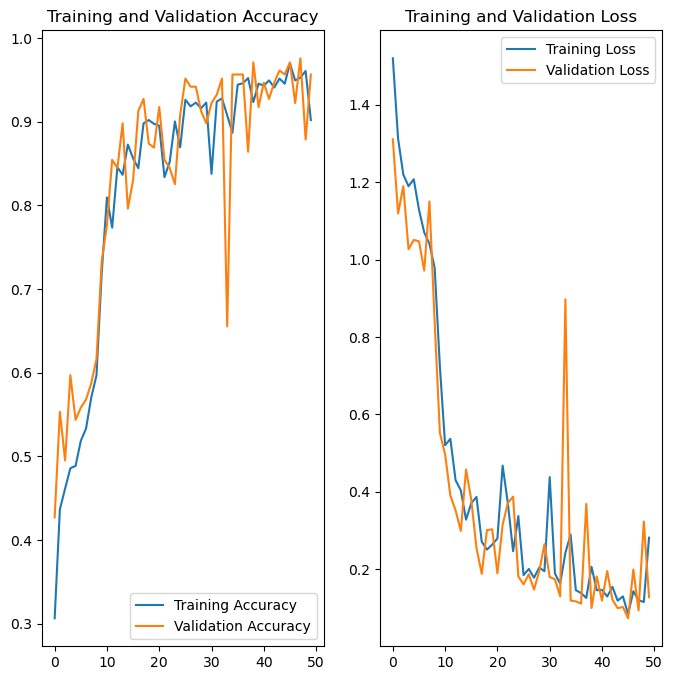

In [114]:
plt.figure(figsize = (8,8))
plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label = 'Training Accuracy')
plt.plot(range(EPOCHS), val_acc, label = 'Validation Accuracy')
plt.legend(loc = 'lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label = 'Training Loss')
plt.plot(range(EPOCHS), val_loss, label = 'Validation Loss')
plt.legend(loc = 'upper right')
plt.title('Training and Validation Loss')

# Make Predictions / inferences on sample images

First image to predict: 
First image actual label:   Brown_Spot
1/1 [==============================] - 0s 251ms/step
Batch Prediction:  Bacterial_Leaf_Blight


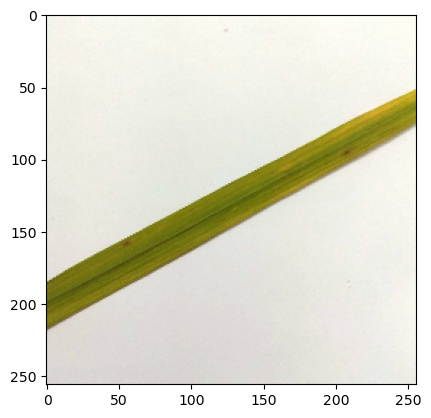

In [42]:
for images_batch, labels_batch in test_ds.take(1):
    #first_image = print(images_batch[0].numpy().astype('uint8'))
    # plt.imshow(images_batch[0].numpy().astype('uint8'))
    first_image = images_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print('First image to predict: ')
    plt.imshow(first_image)
    print('First image actual label:  ' ,class_names[first_label])
    plt.imshow(first_image)
    
    batch_predicion  = model.predict(image_batch)
    print("Batch Prediction: ", class_names[np.argmax(batch_predicion[0])])

In [60]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) #create a batch
    
    predictions = model.predict(img_array)
    
    predicted_class = class_names[np.argmax(predictions[0])]
    cofidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, cofidence

1/1 [==============================] - 0s 14ms/step


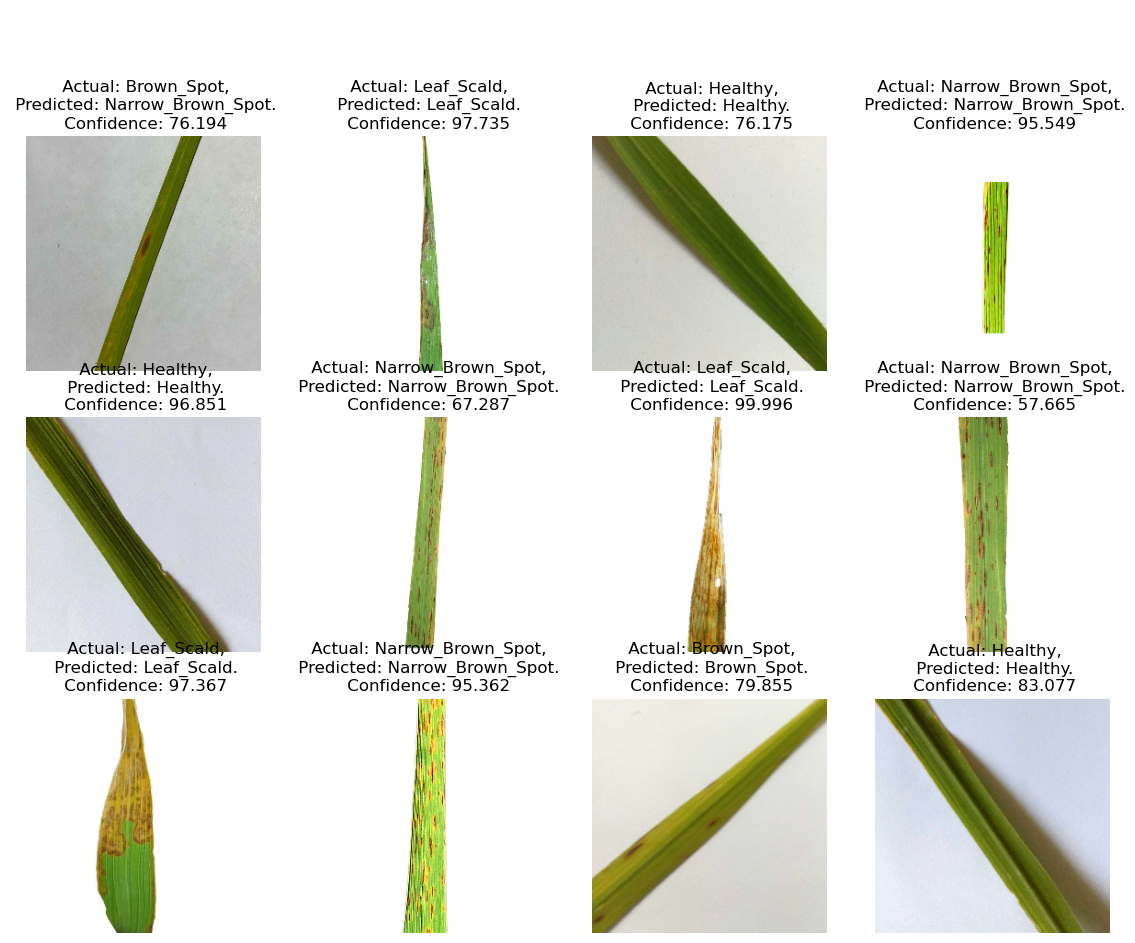

In [61]:
plt.figure(figsize=(14, 14))

for images, labels in test_ds.take(1):  # Corrected variable name 'lables' to 'labels'
    for i in range(12):
        ax = plt.subplot(4, 4, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        ax.set_title(f"\n\n Actual: {actual_class},\n Predicted: {predicted_class}.\n Confidence: {confidence}")  # Corrected 'plot' to 'ax'
        plt.axis("off")
        
plt.show()

In [47]:
import os
model_version = max([int(i) for i in os.listdir("../models") + [0]]) + 1
model.save(f"../models/{model_version}")

INFO:tensorflow:Assets written to: ../models/1/assets


INFO:tensorflow:Assets written to: ../models/1/assets


In [ ]:
#model_version = 1
#model.save(f"../models/{model_version}")

#### Load the model

In [3]:
import tensorflow as tf
from tensorflow import keras

# Load the latest model
loaded_model = keras.models.load_model(f"../models/1")


In [4]:
input_data = test_ds  # Replace with your actual input data
predictions = loaded_model.predict(input_data)

NameError: name 'test_ds' is not defined